In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [2]:
from cnn import utils, layers

In [3]:
import importlib
importlib.reload(utils)
importlib.reload(layers)

<module 'cnn.layers' from '/home/joe/Documents/semester-6/pattern-recognition/ann/cnn/layers.py'>

## Load Data

In [ ]:
# adding color channels to mnist dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert [1, 28, 28] → [3, 28, 28]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

subset_indices = np.arange(5000)

small_train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
small_test_dataset = torch.utils.data.Subset(test_dataset, subset_indices)

train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(small_test_dataset, batch_size=64, shuffle=False)

## Data Preview

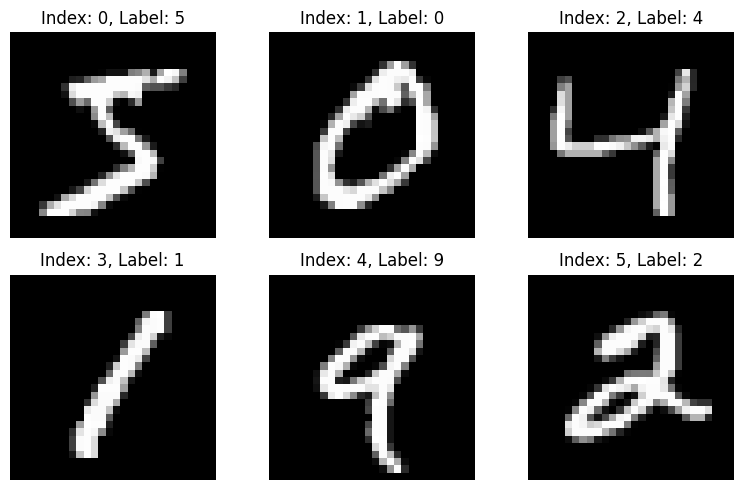

In [5]:
# Set up a 2x3 grid

fig, axes = plt.subplots(2, 3, figsize=(8, 5))

for i in range(6):
    image, label = train_dataset[i]
    tmp_img = image.permute(1, 2, 0)

    ax = axes[i // 3, i % 3]  # Convert index to 2D grid position
    ax.imshow(tmp_img)
    ax.set_title(f"Index: {i}, Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Build Neural Network

In [6]:
def train_loader(dataset, batch_size, shuffle=True):
    """
    Custom train loader function to modify data on the fly.
    """
    data_len = len(dataset)
    indices = list(range(data_len))
    if shuffle:
        np.random.shuffle(indices)

    for i in range(0, data_len, batch_size):
        batch_indices = indices[i : min(i + batch_size, data_len)]
        batch_data = []
        batch_labels = []
        for index in batch_indices:
          image, label = dataset[index]
          # Modify the image data here if needed, example:
          modified_image = image * 2 # Example modification
          batch_data.append(modified_image)
          batch_labels.append(label)

        yield torch.stack(batch_data), torch.tensor(batch_labels)



#Using the custom train loader
train_loader = train_loader(train_dataset, batch_size=64, shuffle=True)

In [7]:
# prompt: write custom test_loader

import numpy as np
def test_loader(dataset, batch_size, shuffle=False):
    """
    Custom test loader function to modify data on the fly.
    """
    data_len = len(dataset)
    indices = list(range(data_len))
    if shuffle:
        np.random.shuffle(indices)

    for i in range(0, data_len, batch_size):
        batch_indices = indices[i : min(i + batch_size, data_len)]
        batch_data = []
        batch_labels = []
        for index in batch_indices:
          image, label = dataset[index]
          # Modify the image data here if needed, example:
          modified_image = image / 2 # Example modification for test data
          batch_data.append(modified_image)
          batch_labels.append(label)

        yield torch.stack(batch_data), torch.tensor(batch_labels)
#Using the custom test loader
test_loader = test_loader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
class ANN:
    def __init__(self):
        self.conv1 = layers.Conv2D(1, 16, 3, stride=1, padding=1)
        self.conv2 = layers.Conv2D(16, 32, 3, stride=1, padding=1)
        self.fc1 = layers.Dense(32 * 7 * 7, 128)
        self.fc2 = layers.Dense(128, 10)
        self.maxPool1 = layers.MaxPool2D(kernel_size=2, stride=2)
        self.maxPool2 = layers.MaxPool2D(kernel_size=2, stride=2)
        self.flatten = layers.Flatten()

    def forward(self, x):
        x = self.conv1.forward(x)
        self.relu1_input = x.copy()
        x = utils.relu(x)

        x = self.maxPool1.forward(x)

        x = self.conv2.forward(x)
        self.relu2_input = x.copy()
        x = utils.relu(x)

        x = self.maxPool2.forward(x)
        x = self.flatten.forward(x)

        x = self.fc1.forward(x)
        self.relu_fc1_input = x.copy()
        x = utils.relu(x)

        x = self.fc2.forward(x)
        return x  # logits (raw output before softmax)

    def predict(self, x):
        logits = self.forward(x)
        probs = utils.softmax(logits)
        return np.argmax(probs, axis=1)

    def backward(self, x, y, logits):
        grad = utils.cross_entropy_backward(utils.softmax(logits), y)
        grad = self.fc2.backward(grad)
        grad = utils.relu_backward(grad, self.relu_fc1_input)
        grad = self.fc1.backward(grad)
        grad = self.flatten.backward(grad)
        grad = self.maxPool2.backward(grad)
        grad = utils.relu_backward(grad, self.relu2_input)
        grad = self.conv2.backward(grad)
        grad = self.maxPool1.backward(grad)
        grad = utils.relu_backward(grad, self.relu1_input)
        grad = self.conv1.backward(grad)

    def update_params(self, lr):
        self.conv1.update_params(lr)
        self.conv2.update_params(lr)
        self.fc1.update_params(lr)
        self.fc2.update_params(lr)

In [9]:
image, label = train_dataset[4]

network = ANN()
predicted_y = network.forward(image.unsqueeze(0))
print(predicted_y)

[[ 0.05361622  0.00275482 -0.01319875  0.03665668 -0.00446529  0.0783326
   0.06127917  0.03156306  0.09450847  0.06914875]]


## Training

In [10]:
def train(model, train_loader, num_epochs=1, learning_rate=0.01):
    for epoch in range(num_epochs):
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            images, labels = batch
            x = images.numpy().reshape(-1, 1, 28, 28)
            y = labels.numpy()

            # Forward pass
            logits = model.forward(x)
            probs = utils.softmax(logits)
            loss = utils.cross_entropy_loss(probs, y)
            total_loss += loss

            # Backward pass and update
            model.backward(x, y, logits)
            model.update_params(learning_rate)

            # Track accuracy
            predictions = np.argmax(probs, axis=1)
            all_preds.extend(predictions)
            all_labels.extend(y)

        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.4f}")

In [11]:
train(network, train_loader, 3, 0.001)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 128 but corresponding boolean dimension is 1568

In [ ]:
# prompt: write the test_loop not the train_loop

def test_loop(model, test_loader):
    correct_predictions = 0
    total_samples = 0

    for images, labels in test_loader:
        images = images.numpy()
        labels = labels.numpy()

        outputs = []
        for image in images:
            image = image[None, ...]
            outputs.append(model.forward(image))

        outputs = np.array(outputs)
        predictions = np.round(outputs)
        correct_predictions += np.sum(predictions == labels)
        total_samples += len(labels)

    accuracy = correct_predictions / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")

test_loop(network, test_loader)
